# ДЗ 29
### Козел А.Г. 9.04-
Выполнить классификацию ттвитов из предоставленного набора данных с использованием рекурентных нейронных сетей по 4 классам. При работе использовать пример example_attenchion.ipnyb

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import models, Sequential, layers, optimizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.metrics import AUC
from keras.regularizers import L1
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation
from bs4 import BeautifulSoup 
import re


### Загрузка данных

In [3]:
colnames=['ID', 'Social_network', 'Sentiment', 'Tweet'] 
df_train = pd.read_csv('twitter_training.csv', names=colnames, header=None)
df_val = pd.read_csv('twitter_validation.csv', names=colnames, header=None)

In [4]:
df_train.head(3)


,ID,Social_network,Sentiment,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...


In [5]:
df_val.head(3)

,ID,Social_network,Sentiment,Tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              74682 non-null  int64 
 1   Social_network  74682 non-null  object
 2   Sentiment       74682 non-null  object
 3   Tweet           73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [7]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              1000 non-null   int64 
 1   Social_network  1000 non-null   object
 2   Sentiment       1000 non-null   object
 3   Tweet           1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [8]:
df_train['Tweet']=df_train['Tweet'].astype(str)
df_val['Tweet']=df_val['Tweet'].astype(str)

In [9]:
df_train.nunique()

ID                12447
Social_network       32
Sentiment             4
Tweet             69492
dtype: int64

In [10]:
df_val.nunique()

ID                1000
Social_network      32
Sentiment            4
Tweet              999
dtype: int64

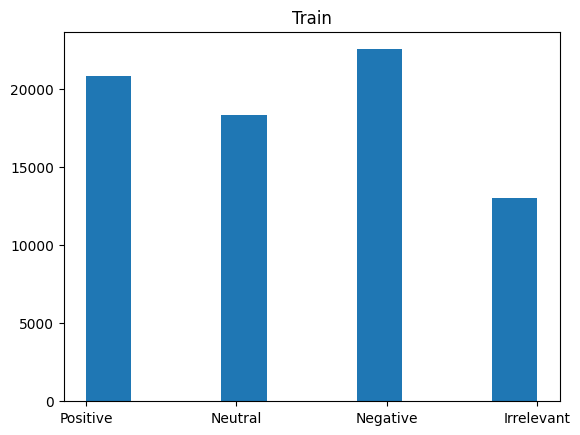

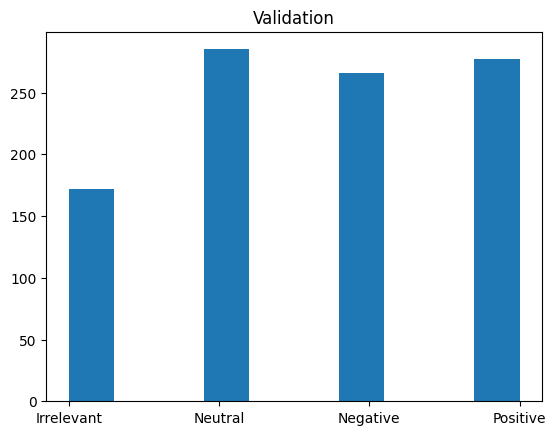

In [11]:
plt.hist(df_train['Sentiment'])
plt.title("Train")
plt.show()
plt.hist(df_val['Sentiment'])
plt.title("Validation")
plt.show()


### Очистка и лемматизация

In [12]:
STOP_WORDS = stopwords.words("english")
STOP_WORDS.remove('not')
STOP_WORDS.remove('no')
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    # очистить текст от тегов и привести к нижнему регистру
    text = BeautifulSoup(text).get_text().lower()
    text = text.replace('http\S+', '').replace('www\S+', '')
    # очистить текст от всех символов кроме букв латинского алфавита
    text = re.sub("[^a-z]", " ", text)
    # разбить текст на слова
    text_words = text.split()
    #выполнить лематизацию текста и удалить стоп-слова
    text = [lemmatizer.lemmatize(word) for word in text_words if word not in STOP_WORDS]
    return (" ".join(text))

In [13]:
df_train['Tweet'] = df_train['Tweet'].apply(lambda x:clean_text(x))


C:\Users\37533\anaconda3\envs\tensorflow\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [14]:
df_val['Tweet'] = df_val['Tweet'].apply(lambda x:clean_text(x))

### Кодировка категориальных признаков (твиттов)

In [15]:
labeles = LabelEncoder()
labels = to_categorical(labeles.fit_transform(df_train['Sentiment']), num_classes=4)
labels.shape


(74682, 4)

### Токенизация

In [16]:
max_len = 128   # отсечение остатка отзывов после 500-го слова
max_words = 26500    # наиболее часто используемые слова

# токенайзер
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
# словарь на основе слов из текста
tokenizer.fit_on_texts(df_train['Tweet'])
# преобразование текста твита в последовательность чисел
sequences = tokenizer.texts_to_sequences(df_train['Tweet'])

In [29]:
word_index = tokenizer.word_index   # получаем количество уникальных слов
print('Уникальных токенов %s'%len(word_index))

Уникальных токенов 26682


### Преобразуем в массив numpy

In [18]:
train_text = pad_sequences(sequences, maxlen=max_len)   # размер (num_samples, max_len)
print(train_text.shape)

(74682, 128)


### Перемешивание данных

In [19]:
indices = np.arange(train_text.shape[0])    
np.random.shuffle(indices)
X = train_text[indices]
y = labels[indices]

### Cоздание обучающего и тестового набора данных

In [20]:
X_test = X[:5000]
y_test = y[:5000]

X_train = X[5000:]
y_train = y[5000:]

### Модель 1

In [21]:
model = Sequential()
model.add(layers.Embedding(input_dim=max_words, output_dim=128))
model.add(layers.Bidirectional(layers.LSTM(units=128, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(units=64)))   
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=64, activation='relu')) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         3392000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [23]:
checkpoint = ModelCheckpoint(filepath='weights1.h5', save_best_only = True, monitor='val_loss')
lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)

In [24]:
with tf.device('/gpu:0'):
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(), metrics=['acc', AUC()])
    history = model.fit(X_train, y_train, epochs=15, validation_split=0.2, batch_size=256, callbacks=[checkpoint,lr_scheduler])

Epoch 1/15
218/218 [==============================] - 87s 323ms/step - loss: 1.0876 - acc: 0.5434 - auc: 0.7864 - val_loss: 0.7827 - val_acc: 0.7078 - val_auc: 0.8977 - lr: 0.0010
Epoch 2/15
218/218 [==============================] - 66s 304ms/step - loss: 0.6307 - acc: 0.7757 - auc: 0.9331 - val_loss: 0.5686 - val_acc: 0.7931 - val_auc: 0.9453 - lr: 0.0010
Epoch 3/15
218/218 [==============================] - 66s 305ms/step - loss: 0.4250 - acc: 0.8511 - auc: 0.9691 - val_loss: 0.4656 - val_acc: 0.8288 - val_auc: 0.9632 - lr: 0.0010
Epoch 4/15
218/218 [==============================] - 66s 304ms/step - loss: 0.3261 - acc: 0.8828 - auc: 0.9814 - val_loss: 0.4159 - val_acc: 0.8556 - val_auc: 0.9711 - lr: 0.0010
Epoch 5/15
218/218 [==============================] - 67s 310ms/step - loss: 0.2743 - acc: 0.9013 - auc: 0.9865 - val_loss: 0.4146 - val_acc: 0.8624 - val_auc: 0.9719 - lr: 0.0010
Epoch 6/15
218/218 [==============================] - 69s 314ms/step - loss: 0.2394 - acc: 0.9130 - 

In [25]:
model.evaluate(X_test, y_test)

157/157 [==============================] - 7s 42ms/step - loss: 0.4870 - acc: 0.8786 - auc: 0.9713


[0.4870274066925049, 0.878600001335144, 0.9712660908699036]

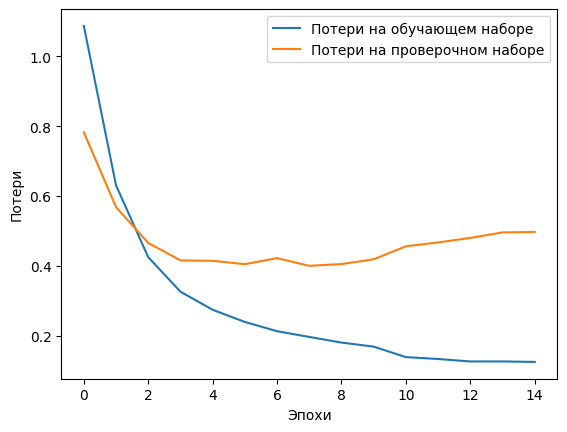

In [26]:
plt.plot(history.history['loss'],label='Потери на обучающем наборе')
plt.plot(history.history['val_loss'], label='Потери на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.show()

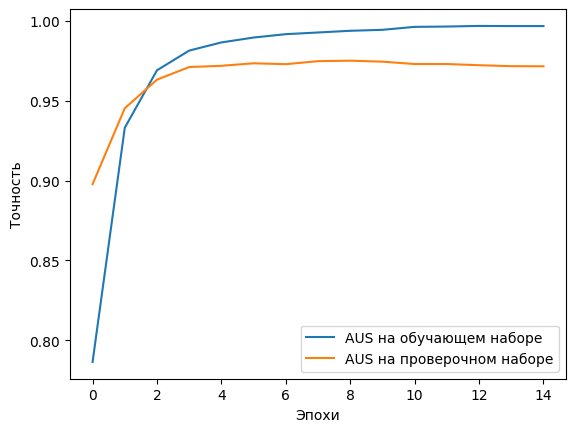

In [28]:
plt.plot(history.history['auc'], label='AUS на обучающем наборе')
plt.plot(history.history['val_auc'], label='AUS на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.show()

### Модель 2

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=128),
    tf.keras.layers.LSTM(64,  return_sequences=True),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         3392000   
                                                                 
 lstm_6 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_7 (LSTM)               (None, 16)                5184      
                                                                 
 dense_6 (Dense)             (None, 64)                1088      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 4)                 260       
                                                                 
Total params: 3,447,940
Trainable params: 3,447,940
No

In [41]:
with tf.device('/gpu:0'):
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(), metrics=['acc', AUC()])
    history = model.fit(X_train, y_train, epochs=15, validation_split=0.2, batch_size=256, callbacks=[checkpoint,lr_scheduler])

Epoch 1/15
218/218 [==============================] - 19s 67ms/step - loss: 1.1204 - acc: 0.5249 - auc_3: 0.7714 - val_loss: 0.8856 - val_acc: 0.6585 - val_auc_3: 0.8659 - lr: 0.0010
Epoch 2/15
218/218 [==============================] - 13s 61ms/step - loss: 0.7049 - acc: 0.7435 - auc_3: 0.9160 - val_loss: 0.6375 - val_acc: 0.7606 - val_auc_3: 0.9310 - lr: 0.0010
Epoch 3/15
218/218 [==============================] - 13s 62ms/step - loss: 0.4976 - acc: 0.8231 - auc_3: 0.9579 - val_loss: 0.5602 - val_acc: 0.7961 - val_auc_3: 0.9484 - lr: 0.0010
Epoch 4/15
218/218 [==============================] - 13s 62ms/step - loss: 0.3861 - acc: 0.8634 - auc_3: 0.9742 - val_loss: 0.4753 - val_acc: 0.8323 - val_auc_3: 0.9621 - lr: 0.0010
Epoch 5/15
218/218 [==============================] - 14s 63ms/step - loss: 0.3122 - acc: 0.8882 - auc_3: 0.9829 - val_loss: 0.4307 - val_acc: 0.8495 - val_auc_3: 0.9686 - lr: 0.0010
Epoch 6/15
218/218 [==============================] - 14s 65ms/step - loss: 0.2669 - 

In [42]:
model.evaluate(X_test, y_test)

157/157 [==============================] - 2s 12ms/step - loss: 0.4668 - acc: 0.8746 - auc_3: 0.9711


[0.4668247103691101, 0.8745999932289124, 0.9711084365844727]

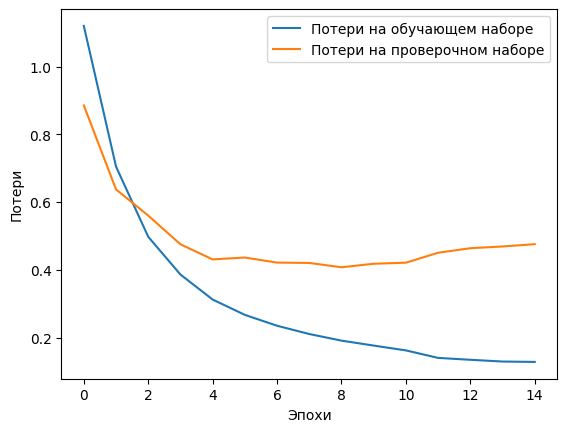

In [43]:
plt.plot(history.history['loss'],label='Потери на обучающем наборе')
plt.plot(history.history['val_loss'], label='Потери на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.show()

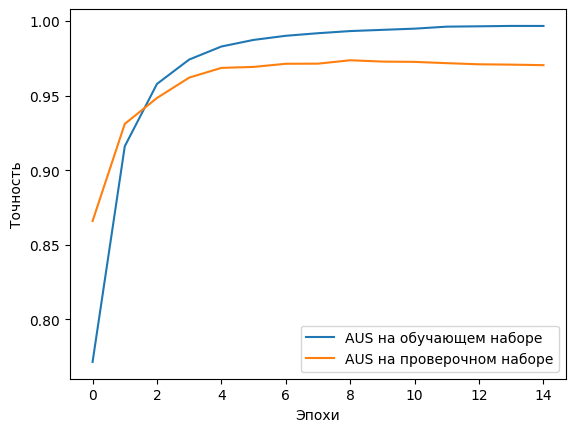

In [44]:
plt.plot(history.history['auc_3'], label='AUS на обучающем наборе')
plt.plot(history.history['val_auc_3'], label='AUS на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.show()